In [7]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import os
import operator


In [8]:
"""
Gathering information about the classical guitar dataset.
We want to know: 
 - How many songs are solos, duets, or trios
 - Key signature per song
 - Time signature per song
 - Number of Key and Time Signature changes per song. 
 - Number of Songs
 - 

"""
path = 'data\\Classical_Guitar_classicalguitarmidi.com_MIDIRip'
list_path = "data\\ValidSingleGuitarSongs"

try:
    songpaths = pd.read_csv(list_path)["File"]
    root = ''
except FileNotFoundError: # PyCharm was giving me a hard time...
    root = "C:\\Users\\Andreas\\Documents\\CS397Pardo\\Project\\MelodyLSTM\\"
    path = root + path
    list_path = root + list_path
    songpaths = pd.read_csv(list_path)["File"]


In [10]:
data = []
tempo_data = pd.DataFrame(columns=["File","Tempo", "Longest Note", "Shortest Note"])

key_names = ["C", "Db", "D", "Eb", "E", "F", "F#", "G", "Ab", "A", "Bb", "B"]
key_map = {}
for i in range(24):
    key_map[i] = key_names[i % 12] + "m" if i >= 12 else key_names[i % 12]


In [23]:
def find_primary_signature(signature_list):
    signatures = {}
    if not signature_list:
        return
    for signature in signature_list:
        if isinstance(signature, pretty_midi.TimeSignature):
            key = str(signature.numerator) + "/" +str(signature.denominator)
        elif isinstance(signature, pretty_midi.KeySignature):
            key = key_map[signature.key_number]
        else:
            raise ValueError("Key signature nor Time Signature List was passed")

        if key in signatures.keys():
            signatures[key] += signature.time
        else:
            signatures[key] = signature.time
 
    return max(signatures, key=signatures.get)

In [11]:
single_instrument_path = []
single_midis = []

for i in range(len(songpaths)):
    try:
        midi_data = pretty_midi.PrettyMIDI(path + "\\" + songpaths[i])
    except UnicodeDecodeError:
        print("Corrupted File found: " + songpaths[i])
        continue
    except IOError:
        print("Corrupted File found: " + songpaths[i])
        continue
    except ValueError:
        print("Corrupted File found: " + songpaths[i])
        continue

    # data.append(len(midi_data.instruments))
    if len(midi_data.instruments) == 1:
        single_instrument_path.append(songpaths[i])
        single_midis.append(midi_data)
        tempo_change_times, tempi = midi_data.get_tempo_changes()
        tempo = tempi[0] if tempi.shape[0] else midi_data.estimate_tempo()
        note_length = lambda x: x.end - x.start
        tempo_data.loc[i] = [songpaths[i],
                             tempo,
                            note_length(max(midi_data.instruments[0].notes, key=note_length)) * tempo / 60,
                            note_length(min(midi_data.instruments[0].notes, key=note_length)) * tempo / 60]
        beat_locations = midi_data.get_beats()


C:\ProgramData\Miniconda3\envs\MelodyLSTM\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [32]:
with open(list_path, "w") as file:
     file.truncate()
     file.writelines("%s\n" % path for path in single_instrument_path)

In [38]:
tempo_data.to_csv(root + "\\data\\tempo_data.csv")


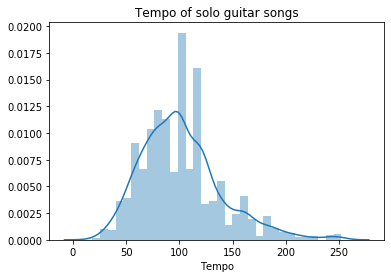

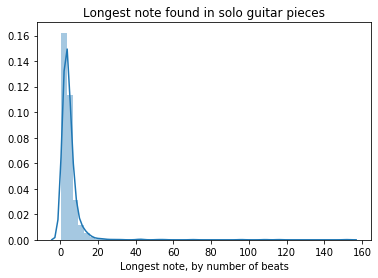

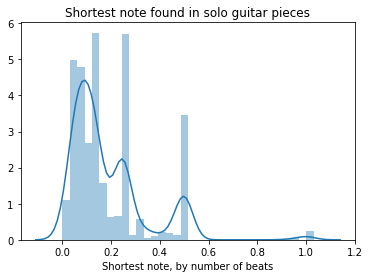

In [30]:
#
# plt.hist(data, bins=30)
# plt.show()

sn.distplot(tempo_data["Tempo"])
plt.title("Tempo of solo guitar songs")
plt.xlabel("Tempo")
plt.show()

sn.distplot((tempo_data["Longest Note"]))
plt.title("Longest note found in solo guitar pieces")
plt.xlabel("Longest note, by number of beats")
plt.show()

sn.distplot((tempo_data["Shortest Note"]))
plt.title("Shortest note found in solo guitar pieces")
plt.xlabel("Shortest note, by number of beats")
plt.show()

The smallest time steps for some tracks are quite small. 
How many songs have less than .25 of a beat?

In [12]:
small_tempo_df = tempo_data[tempo_data["Shortest Note"] <  .249]

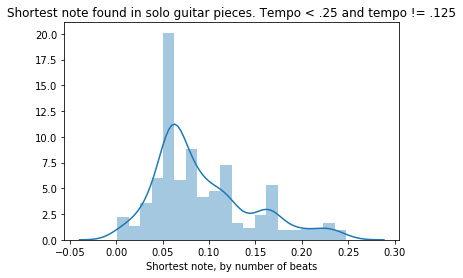

866

In [21]:
## sixteenth note is .125, remove it
small_tempo_df = small_tempo_df[np.abs(small_tempo_df["Shortest Note"] - .125) > .001]
training_df = tempo_data[(tempo_data["Shortest Note"] >  .249) | (np.abs(tempo_data["Shortest Note"] - .125) < .001)]
sn.distplot((small_tempo_df["Shortest Note"]))
plt.title("Shortest note found in solo guitar pieces. Tempo < .25 and tempo != .125")
plt.xlabel("Shortest note, by number of beats")
plt.show()
small_tempo_df.shape[0]

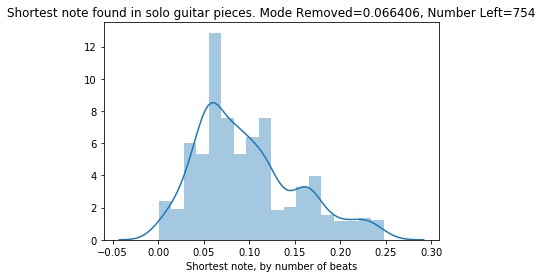

KeyboardInterrupt: 

In [15]:
# Find each mode, remove mode from dataset, generate graph and number of 
from scipy.stats import mode
mode_tempo_df = small_tempo_df.copy(deep=True)
threshold = .005

while mode_tempo_df.shape[0]:
    next_mode, count = mode(mode_tempo_df["Shortest Note"])
    _tempo_df = mode_tempo_df[np.abs(mode_tempo_df["Shortest Note"] - next_mode) < threshold]
    mode_tempo_df = mode_tempo_df[np.abs(mode_tempo_df["Shortest Note"] - next_mode) > threshold]
    sn.distplot((mode_tempo_df["Shortest Note"]))
    plt.title("Shortest note found in solo guitar pieces. Mode Removed=%f, Number Left=%i"%
              (next_mode, mode_tempo_df.shape[0]))
    plt.xlabel("Shortest note, by number of beats")
    plt.show()


In [23]:
# A training set of 735 songs with the shortest notes being sixteenth notes or triplets.
training_set_list = "\\data\\classical_guitar_training_set"
training_df["File"].to_csv(root + training_set_list, index=False)
    

C:\ProgramData\Miniconda3\envs\MelodyLSTM\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
